<a href="https://colab.research.google.com/github/storimaging/Notebooks/blob/main/ImageGeneration/Maximum_entropy_model_for_CNN_texture_synthesis_with_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Texture synthesis with Maximum Entropy

## Introduction

This practical session implements the texture synthesis algorithm developed on [Maximum entropy methods for texture synthesis: theory and practice,  V. De Bortoli, A. Desolneux, A. Dur mus, B. Galerne, A. Leclaire, SIAM Jour nal on Mathematics of Data Science (SIMODS), 2021](https://arxiv.org/pdf/1912.01691.pdf)

**Texture Synthesis:** 

Given an input texture image, produce an output texture image that is both visually similar and pixel-wise different from the input texture. The output image should ideally be perceived as another part of the same large piece of homogeneous material from which the input texture originated.

**References:**

* Public repository: https://gitlab.com/vdeborto/macrocanonical-synthesis/-/tree/master/
* Functions to manage images: https://github.com/trsvchn/deep-textures

**Authors:**
* [Bruno Galerne](https://github.com/bgalerne)
* Lucía Bouza

## Underlying principle

**Framework: Macrocanonical model**. 

We are looking for the parameters $\theta\in\mathbb{R}^p$ 
such that the exponential model
$$
\pi_{\theta}(x) \propto e^{-V(x,\theta)} dx
$$
where
$$ 
V(x,\theta) = \theta \cdot (f(x)-f(x_0)) + J(x)
$$
with

* $x_0$ is the target texture, 

* $f:\mathbb{R}^d \to \mathbb{R}^p$ is the spatial average of the feature responses of each selected layers (multiplied by $\beta = 128$).

* $J(x) = \frac{\epsilon}{2}  \left\| x \right\|^2$

such that $\theta$ is a solution of the macrocanonical problem, that is, 
$$
\mathbb{E}_{\pi_{\theta}}[f(X)] = f(x_0)
$$
and $\pi_{\theta}$ has maximal entropy.

The pseudo-code of the algorithm is then the following.


**SOUL algorithm**

* Initialization: $\theta \leftarrow 0$; $X_0^0 \in \mathbb{R}^d$
* For $n = 1, \ldots, N$,

  * $m_n$ steps of Langevin diffusion: for $k=0,\ldots,m_n-1$, 
         
  $$
  X_{k+1}^n = X_k^n - \gamma_{n+1} \nabla_x V(X_k^n,\theta_n) + \sqrt{2\gamma_{n+1}} Z_{k+1}^n
  $$
  with $Z_{k+1}^n \sim \mathcal{N}(0,I)$

 * Update $\theta$ with Langevin intermediary states:

  $$
  \theta_{n+1} = \mathsf{Proj}_{\Theta}\left( \theta_n + \frac{\delta_{n+1}}{m_n} \sum_{k=1}^{m_n} f(X_k^n) - f(x_0)\right)
  $$

 * Set warm start for next step: $X_0^{n+1} = X_{m_n}^n$


**In practice:**

* The initialization $X_0^0$ is an ADSN realization (we will see it later).
* We do not use projections.
* $\epsilon = 0.1$
* $\gamma$ and $\delta$ are fixed.
* $m = 1$, so we do one update of $x$, one update of $\theta$, and so on. 
* Use the layers [1, 3, 6, 8, 11, 13, 15, 24, 26, 31] for optimization.




## Importing packages

Below is a list of packages needed to implement texture synthesis. PyTorch version used to run this notebook is **1.11.0+cu113** (to check the installed version, use `torch.__version__`)

* `torch` (indispensable packages for neural networks with PyTorch)
* `torchvision.transforms.functional` (transform images into tensors)
* `torchvision.models` (get the vgg network)
* `PIL.Image, matplotlib.pyplot` (display of images and graphics)
* `os` (interactions with the operating system)

In [ ]:
import torch
import torch.nn as nn
from torch.nn.functional import mse_loss
import torchvision.models as models
from torchvision.transforms.functional import resize, to_tensor, normalize, to_pil_image

from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
from google.colab import widgets

To import the solutions, execute the following cell. If you are using a Windows system, comment the `os.system` line, download the file by hand, and place it in the same folder as the notebook.

In [ ]:
#os.system("wget -nc https://raw.githubusercontent.com/storimaging/Notebooks/main/ImageGeneration/Solutions/TSMaximumEntropy.py")
#from TSMaximumEntropy import *

## Loading images

In the next section we will load images. Here we'll just get, display, and save the image, without making any changes to it.

In [ ]:
texture_imgnames = ["bois.png", "briques.png", "mur.png", "tissu.png", 
                    "nuages.png","pebbles.jpg","wall1003.png", "osier12.png",
                    "paille17c2.png","bark.png","coffee.png","flower.png",
                    "rock.png","sweet.png"]

for fname in texture_imgnames:
    os.system("wget -c https://raw.githubusercontent.com/storimaging/Images/main/Textures/"+fname)
    img = Image.open(fname)

## Set a device

Next, we need to choose which device to run the algorithm on. Running the algorithm on large images takes longer and will go much faster when running on a GPU. We can use `torch.cuda.is_available()` to detect if there is a GPU available. Next, we set the `torch.device`. The `.to(device)` method is used to move tensors or modules to a desired device, we will use it in next sections. 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is", device)
!nvidia-smi

## Data preparation

An important detail to note is that the neural network model we will use is trained on preprocessing images. We will need to apply the same preprocessing step to the image tensor before sending it into the network.

The preprocessing step consists only on subtracting the mean RGB value, computed on the training set (Imagenet), from each pixel. The original PIL images have values between 0 and 255, but when transformed into torch tensors, their values are converted to be between 0 and 1. Therefore, after subtracting the mean (`[0.485, 0.456, 0.406]`), it is necessary to multiply the tensor by 255 to the values be between 0 and 255 again. 
Read the following [paper](https://arxiv.org/pdf/1409.1556.pdf) on section 2.1 to learn more details about VGG training. 

Here are some helper functions for loading, displaying and transforming into tensors.

In [ ]:
#@title
# Utilities
# Functions to manage images

MEAN = (0.485, 0.456, 0.406)

# Based on Taras Savchyn's code
# https://github.com/trsvchn/deep-textures/blob/main/deeptextures/utils.py
def prep_img(image: str, size=None, mean=MEAN):
    """Preprocess image.
    1) load as PIl
    2) resize
    3) convert to tensor
    5) remove alpha channel if any
    4) substract mean and multipy by 255
    """
    im = Image.open(image)
    texture = resize(im, size)
    tensor = to_tensor(texture).unsqueeze(0)
    if tensor.shape[1]==4:
        print('removing alpha chanel')
        tensor = tensor[:,:3,:,:]
    mean = torch.as_tensor(mean, dtype=tensor.dtype, device=tensor.device).view(-1, 1, 1)
    tensor.sub_(mean).mul_(255)
    return tensor

# Based on Taras Savchyn's code
# https://github.com/trsvchn/deep-textures/blob/main/deeptextures/utils.py
def denormalize(tensor: torch.Tensor, mean=MEAN):

    tensor = tensor.clone().squeeze() 
    mean = torch.as_tensor(mean, dtype=tensor.dtype, device=tensor.device).view(-1, 1, 1)
    tensor.mul_(1./255).add_(mean)
    return tensor

# Taras Savchyn's code
# https://github.com/trsvchn/deep-textures/blob/main/deeptextures/utils.py
def to_pil(tensor: torch.Tensor):
    """Converts tensor to PIL Image.
    Args: tensor (torch.Temsor): input tensor to be converted to PIL Image of torch.Size([C, H, W]).
    Returns: PIL Image: converted img.
    """
    img = tensor.clone().detach().cpu()
    img = denormalize(img).clip(0, 1)
    img = to_pil_image(img)
    return img


def printResults(target, opt_img, iter, loss):
    """ Displays the intermediate results of the main iteration
    """
    print('Iteration: %d, loss: %f'%(iter, loss.item()))
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))
    axes[0].imshow(to_pil(target.squeeze(0)))
    axes[0].set_title('Original texture')
    axes[1].imshow(to_pil(opt_img.squeeze(0)))
    axes[1].set_title('Synthesis')
    fig.tight_layout()
    plt.pause(0.05)


def compare_images(imgs):
    labels = ['image ' + str(i) for i in range(len(imgs))]
    tb = widgets.TabBar(labels, location='top')
    for i, img in enumerate(imgs):
        with tb.output_to(i, select=(i == 0)):
            display(img)

## Model

Now we need to define the neural network and import a pretrained model. We will use a 19-layer VGG network from PyTorch and the pretrained model used on the [paper](https://arxiv.org/abs/1505.07376). We use this particular model because it is a normalized version of the VGG network. Here, the weights are scaled such that the mean activation of each filter over training images and positions is equal to 1. The benefit of normalization is that losses based on features extracted from different layers of the network will have comparable magnitude. 
On this [github site](https://github.com/corleypc/vgg-normalize) you can find a detailed explanation of how  normalization works and an implementation to do it. Also [this thread](https://stats.stackexchange.com/questions/361723/weight-normalization-technique-used-in-image-style-transfer) can help to understand the process.  

VGG's PyTorch implementation is a module split into two sequential child modules: features (containing convolution and pooling layers) and classifier (containing fully connected layers). For the texture synthesis task, we are only interested in the layers of the features module. We won't let the parameters change: the network is already trained and used as an image transformation.


In [ ]:
!gdown 1lLSi8BXd_9EtudRbIwxvmTQ3Ms-Qh6C8

In [ ]:
cnn = models.vgg19(pretrained=False).features.to(device)
pretrained_dict = torch.load('vgg_conv.pth')

for param, item in zip(cnn.parameters(), pretrained_dict.keys()): 
    param.data = pretrained_dict[item].type(torch.FloatTensor).to(device)

cnn.requires_grad_(False)

We will slithgly change the network so that $f$ is differentiable. We will change Relu for CeLu and Max Pooling for Average Pooling.

In [ ]:
# Valentin de Bortoli's code
# https://gitlab.com/vdeborto/macrocanonical-synthesis/-/tree/master/
def differentiable(cnn):
    """
    This function replaces non differentiable non-linear functions
    in the network by differentiable ones.
    """

    for i, layer in cnn.named_modules():
        if isinstance(layer, nn.ReLU):
            cnn[int(i)] = nn.CELU(inplace=True)
        if isinstance(layer, nn.MaxPool2d):
            cnn[int(i)] = nn.AvgPool2d(2, stride=2, padding=0, ceil_mode=False)

# Replace no differentiable functions
differentiable(cnn)

According to the algorithm explained at the beginning of this notebook, we need to access the outputs of some selected intermediate layers. In order to access the outputs of the layers on the PyTorch VGG19 network, we need to register a hook on each layer we need. Hooks are functions, which can be attached to each layer and called each time the layer is used. You can register a hook before or after the forward pass, or after the backward pass. We will define a function `save_output` that will be triggered after the forward pass, for each layer of the `features` module. 

The layer outputs will be stored in a dictionary where the key is the layer index and the value is the layer output tensor.

We must define which layers will be part of the optimization. Using the indices of layers, we select the layers to use in the algorithm. We will choose indices [1, 3, 6, 8, 11, 13, 15, 24, 26, 31]. 

In [ ]:
# Initialize outputs dic
outputs = {}

# Hook definition
def save_output(name):
    
    # The hook signature
    def hook(module, module_in, module_out):
        outputs[name] = module_out
    return hook

# Define layers
layers = [1,3, 6, 8, 11, 13, 15, 24, 26, 31]

# Register hook on each layer with index on array "layers"
for layer in layers:
    handle = cnn[layer].register_forward_hook(save_output(layer))

The function $f$ corresponds to the spatial mean of the VGG-19 layers calculated by the `mean_Spatial` function below.

In [ ]:
# for computing the spatial average of the feature responses of each selected layer
def mean_Spatial (input: torch.Tensor):  

    mean_input = torch.mean(input.squeeze(), axis=(1,2))  
    return mean_input

def feature_statistics(outputs: torch.Tensor, layers):

    meansOutputs = [mean_Spatial(outputs[key]) for key in layers] 
    return torch.cat(meansOutputs)

## Initialization

We will use the ADSN model to initialize the synthesis.

**ADSN initialization:** 

Let $h\in\mathbb{R}^{M\times N\times 3}$ be a an image, $m = (m_r, m_g, m_b)$ be the mean color of $h$ and $X$ be a Gaussian white noise image.
The random image
$$
Y = m + \frac{1}{\sqrt{MN}}
\begin{pmatrix}
\left( h_r - m_r \right) \ast X\\
\left( h_g - m_g \right) \ast X\\
\left( h_b - m_b \right) \ast X
\end{pmatrix},~~~X\in\mathbb{R}^{M\times N}~\text{a Gaussian white noise},
$$
is the ADSN associated with $h$.

In [ ]:
def adsn(input):
    """
    Compute ADSN initialization. 
    input is supposed to be a tensor of size 1 x c x h x w
    """
    tnsr = input.squeeze(0)
    c, h, w = tnsr.size() 
    m = torch.mean(tnsr, axis=(1,2))
    X = torch.randn(h, w).to(device)
    Y = torch.empty_like(tnsr)
    sqrtHW = np.sqrt(h*w)

    for i in range(c):
        tnsrnorm = (tnsr[i,:,:]-m[i])/sqrtHW
        Y[i,:,:] = torch.real(torch.fft.ifft2(torch.fft.fft2(tnsrnorm) * torch.fft.fft2(X))) + m[i]

    return Y.unsqueeze(0)

In the following we choose the target texture. This image is converted into a tensor, performing normalization and resizing. 


In [ ]:
######################################################
### This section allows you to change target image ###
######################################################
# Select input image: 
#  ["bois.png", "briques.png", "mur.png", "tissu.png", 
#   "nuages.png","pebbles.jpg","wall1003.png", "osier12.png",
#   "paille17c2.png","bark.png","coffee.png","flower.png",
#   "rock.png","sweet.png"]
input_image_name = "coffee.png"
img_size = 256

# Prepare texture data
target = prep_img(input_image_name, img_size).to(device)

# set seed to reproduce examples
torch.manual_seed(123)

Then, we draw the ADSN initialization. This tensor needs to be optimized, so we set `requires_grad` to `True`.

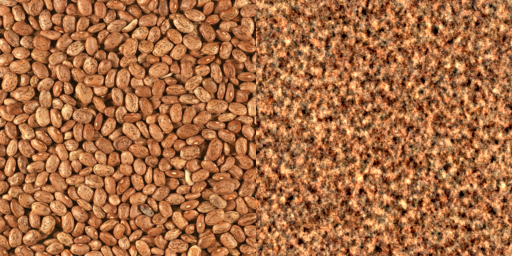

In [ ]:
#init image with adsn from target image (normalized)
x = adsn(target)
x.requires_grad=True

# print images
display(to_pil(torch.cat((target, x), axis=3)))

## Running texture synthesis

We are now able to perform texture synthesis. For each iteration, we update the image $x$ and then update the weights $\theta$.


### Exercise A:
1. Fill in the ```#TODO``` segments of the code to perform texture synthesis using the SOUL algorithm. The formula are rewritten below.
2. What is the dimension $p$ here? 
2. What happens when $\gamma$ is augmented?
3. Is the ADSN initialization important?

**SOUL algorithm**

* Initialization: $\theta \leftarrow 0$; $X_0^0 \in \mathbb{R}^d$ an ADSN realization
* For $n = 1, \ldots, N$,

  * $m_n = 1$ step of Langevin diffusion: for $k=0,\ldots,m_n-1$, 
         
  $$
  X_{k+1}^n = X_k^n - \gamma_{n+1} \nabla_x V(X_k^n,\theta_n) + \sqrt{2\gamma_{n+1}} Z_{k+1}^n
  $$
  with $Z_{k+1}^n \sim \mathcal{N}(0,I)$

 * Update $\theta$ with Langevin intermediary states:

  $$
  \theta_{n+1} = \mathsf{Proj}_{\Theta}\left( \theta_n + \frac{\delta_{n+1}}{m_n} \sum_{k=1}^{m_n} f(X_k^n) - f(x_0)\right)
  $$

 * Set warm start for next step: $X_0^{n+1} = X_{m_n}^n$


**In practice:**
* The initialization $X_0^0$ is an ADSN realization (see below).
* $f:\mathbb{R}^d \to \mathbb{R}^p$ is the spatial average of the feature responses of each selected layers **multiplied by $\beta = 128$**.
* We do not use projections.
* $\epsilon = 0.1$
* $\gamma$ and $\delta$ are fixed (see value in code below).
* $m = 1$, so we do one update of $x$, one update of $\theta$, and so on. 
* Use the layers [1, 3, 6, 8, 11, 13, 15, 24, 26, 31] for optimization.

In [ ]:
def textureSynthesis (n_iters, log_every, delta, gamma, epsilon, cnn, target, outputs, layers, x, beta):

    # Compute just once means spatial of activations of the target image. 
    cnn(target)
    featureTargetStatistics = feature_statistics(outputs, layers)

    # initialize weights (Theta)
    theta = torch.zeros_like(featureTargetStatistics)

    # Initialize list of intermediary images
    xpil_list = []

    # Forward pass using x. Get activations of selected layers for image x (outputs).
    x.requires_grad=True
    cnn(x)

    for iter in range(n_iters):
        
        if x.grad is not None:
            x.grad.zero_()
      
        # Compute V and its gradient with respect to x:

        # TODO

        # update image
        with torch.no_grad():
            
            # TODO

        # Forward pass using x. Get activations of selected layers for image x (outputs).
        cnn(x)

        # update weights thetas:
        with torch.no_grad():
            # TODO

        # Display results: print Loss value and show image
        if (iter==0 or iter % log_every == log_every-1):
            print('Iteration: ', iter)
            display(to_pil(torch.cat((target, x), axis=3)))
            # Store for comparison:
            xpil_list.append(to_pil(x.clone().detach()))

    return xpil_list

### Solution exercise A

In [ ]:
n_iters = 3000
log_every = n_iters//3

# steps and epsilon
beta = 128
delta = 8e-4 ##10e-1
gamma = 2*10e-6 
epsilon = 0.1

xpil_list = textureSynthesisA (n_iters, log_every, delta, gamma, epsilon, cnn, target, outputs, layers, x, beta)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

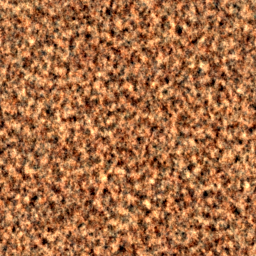

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

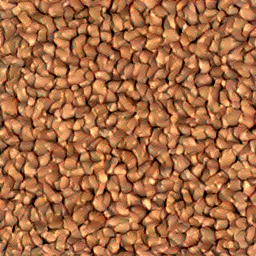

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

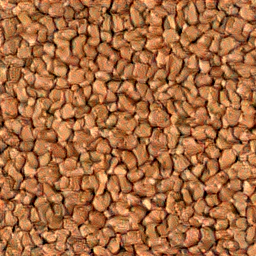

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

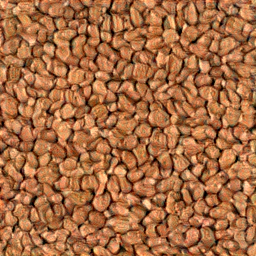

<IPython.core.display.Javascript object>

In [ ]:
compare_images(xpil_list)

In [ ]:
p = feature_statistics(outputs, layers).size()
print(p)

torch.Size([2688])


### Exercise B

Add the mean and covariance to the optimization statistics to reimpose the color distribution.

Run this cell to change target image and restart initialization. 

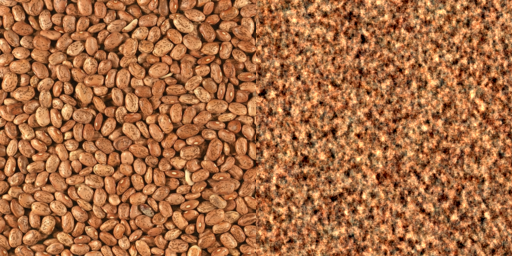

In [ ]:
######################################################
### This section allows you to change target image ###
######################################################
# Select input image: 
#  ["bois.png", "briques.png", "mur.png", "tissu.png", 
#   "nuages.png","pebbles.jpg","wall1003.png", "osier12.png",
#   "paille17c2.png","bark.png","coffee.png","flower.png",
#   "rock.png","sweet.png"]
input_image_name = "coffee.png"
img_size = 256

# Prepare texture data
target = prep_img(input_image_name, img_size).to(device)
######################################################

#init image with adsn from target image (normalized)
x = adsn(target)

# display images
display(to_pil(torch.cat((target, x), axis=3)))
plt.pause(0.05)

### Solution exercise B

In [ ]:
n_iters = 3000
log_every = n_iters//3

# steps and epsilon
beta = 128
delta = 8*10e-4 #10e-1
gamma = 2*10e-6
epsilon = 0.1

xpil_list = textureSynthesisB (n_iters, log_every, delta, gamma, epsilon, cnn, target, outputs, layers, x, beta)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

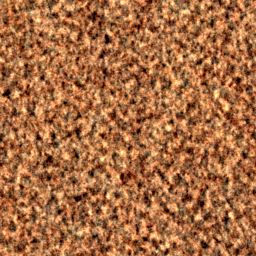

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

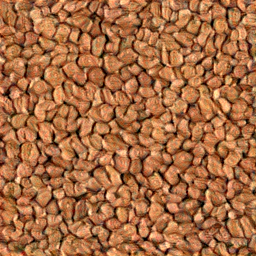

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

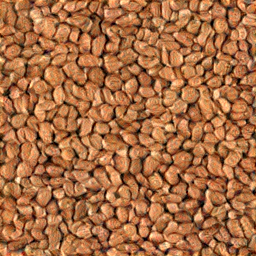

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

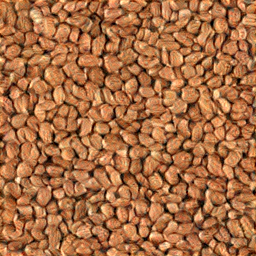

<IPython.core.display.Javascript object>

In [ ]:
compare_images(xpil_list)